# Спортивный анализ данных. Платформа Kaggle

## Урок 6. Feature Engineering, Feature Selection, part II

### Домашнее задание:

Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

**[Задание 0](#task0):**
 Выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

**[Задание 1](#task1):**
 Использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

**[Задание 2](#task2):**
 Удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.
 
**[Задание 3](#task3):** 
 Использовать permutation importance , выполнить задание 1 и 2.
 
**[Задание 4](#task4):** 
 Использовать shap, выполнить задание 1 и 2.
 
**[Задание 5](#task5):**
 Построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

## Подключение библиотек и скриптов

import datetime
import warnings
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Модель
import xgboost as xgb
import catboost as cb

# Метрика
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

warnings.simplefilter("ignore")
%matplotlib inline

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Модель
import xgboost as xgb
import catboost as cb

# Метрика
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
# разварачиваем выходной дисплей, чтобы увидеть больше столбцов и строк a pandas DataFrame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
def reduce_mem_usage(df):
    '''Сокращение размера датафрейма за счёт изменения типа данных'''
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
# input
TRAIN_DATASET_PATH = '../../data/assignment_2_train.csv'
TEST_DATASET_PATH = '../../data/assignment_2_test.csv'

## Загрузка данных

In [5]:
# Тренировочные данные
# train = pd.read_csv(TRAIN_DATASET_PATH, header = none)  # если надо скрыть названия столбцов
train = pd.read_csv(TRAIN_DATASET_PATH)
df_train =reduce_mem_usage(train)  # Уменьшаем размер данныхM
df_train.head(2)

Memory usage of dataframe is 541.08 MB
Memory usage after optimization is: 262.48 MB
Decreased by 51.5%


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [6]:
# Тестовые данные
# leaderboard = pd.read_csv(TEST_DATASET_PATH)
# df_test =reduce_mem_usage(leaderboard)  # Уменьшаем размер данных

# df_test.head(2)

In [7]:
df_train.set_index('TransactionID', inplace=True)
# X_test['DistrictId'] = X_test['DistrictId'].astype(str)
# target = df_train["isFraud"]
df_train.head(2)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.

__Числовых признаки__

In [8]:
numerical_features = df_train.select_dtypes(exclude=["category"])
numerical_features = numerical_features.columns.tolist()
#numerical_features.remove('TransactionID')
numerical_features.remove('isFraud')
#numerical_features

In [9]:
# Общее количество записей в датафрейме = 180 000
# Исключаем такие поля содержащие меньше 100 000 значений,
# из предполажения, что значение этих полей несущественно (всегда можно этот параметр проварьировать).
 
# numerical_features = [
# # 'TransactionID',  # Индекс
# # 'isFraud',  # Целевой параметр
# 'TransactionDT',  # Временя совершения транзакции
# 'TransactionAmt',  # Сумма транзакции
# 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2',
# 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D4', 'D10', 'D15', #'D11',##<50 000
# 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 
# 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47',
# 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65',
# 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83',
# 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99','V100','V101',
# 'V102','V103','V104','V105','V106','V107','V108','V109','V110','V111','V112','V113','V114','V115','V116','V117','V118','V119',
# 'V120','V121','V122','V123','V124','V125','V126','V127','V128','V129','V130','V131','V132','V133','V134','V135','V136','V137',
# 'V280','V281','V282','V283','V284','V285','V286','V287','V288','V289','V290','V291','V292','V293','V294','V295','V296','V297',
# 'V298','V299','V300','V301','V302','V303','V304','V305','V306','V307','V308','V309','V310','V311','V312','V313','V314','V315',
# 'V316','V317','V318','V319','V320','V321'] 

__Обрабатка категориальные признаков__

In [10]:
catigorical_features = df_train.select_dtypes(include=["category"])
catigorical_features = catigorical_features.columns.tolist()
# catigorical_features

In [11]:
# catigorical_features = [
# 'ProductCD',  # 180000 non-null  category
# 'card4',  # 179992 non-null  category
# 'card6',  # 179993 non-null  category
# 'P_emaildomain',  # 151560 non-null  category
# 'R_emaildomain',  # 60300 non-null   category
# 'M1',  # 61749 non-null   category
# 'M2',  # 61749 non-null   category
# 'M3',  # 61749 non-null   category
# 'M4',  # 83276 non-null   category
# 'M5',  # 61703 non-null   category
# 'M6',  # 105652 non-null  category
# 'M7',  # 31652 non-null   category
# 'M8',  # 31652 non-null   category
# 'M9'  # 31652 non-null   category
# ]

In [12]:
# Каждой категории сопоставляет целое число (номер категории) - https://dyakonov.org/2016/08/03/python-категориальные-признаки/
from sklearn.preprocessing import LabelEncoder

def catigorical_features_prepare(df, cat_features_drop = 0, catigorical_features=[]):
    # Подготовка категориальных признаков
    if catigorical_features == []:
        catigorical_features = df.select_dtypes(include=["category"])
        catigorical_features = catigorical_features.columns.tolist()

    # заполняем пропуски в категориалиных признаках
    for col in catigorical_features:
        df[col] = df[col].cat.add_categories('Unknown')
        df[col].fillna('Unknown', inplace =True) 
    
    le = LabelEncoder()
    # создаём новые категориальные признаки - каждой категории сопоставляет целое число (номер категории) 
    for cat_colname in df[catigorical_features].columns:
        le.fit(df[cat_colname])
        df[cat_colname+'_le'] = le.transform(df[cat_colname])
    
    # список новых категориальных признаков
    catigorical_features_le = catigorical_features.copy()
    for key, value in enumerate(catigorical_features):
        catigorical_features_le[key] = value + '_le'
    
    print(catigorical_features)
    # удаляем необработанные категориальные признаки при необходимости
    if cat_features_drop == 1:
        df.drop(catigorical_features, axis=1, inplace=True)
        
    return df, catigorical_features_le

In [13]:
data = df_train.copy()
data, catigorical_features_le = catigorical_features_prepare(data, catigorical_features)
data[catigorical_features_le].head(2)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


,ProductCD_le,card4_le,card6_le,P_emaildomain_le,R_emaildomain_le,M1_le,M2_le,M3_le,M4_le,M5_le,M6_le,M7_le,M8_le,M9_le
TransactionID,,,,,,,,,,,,,,
2987000,4,2,2,0,0,1,1,1,2,0,1,2,2,2
2987001,4,3,2,17,0,2,2,2,0,1,1,2,2,2


In [14]:
# data = df_train.copy()
# data, catigorical_features_le = catigorical_features_prepare(data)
# data[catigorical_features_le + catigorical_features].head(2)

In [15]:
# data = df_train.copy()
# data, catigorical_features_le = catigorical_features_prepare(data, 1)
# data[catigorical_features_le].head(2)

Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

__Добавляем поля из 5 урока задание 1__

In [16]:
def function(x):
    base_date = datetime.datetime(2017, 10, 1)
    new_date = base_date + datetime.timedelta(seconds=x)
    year = new_date.year
    month = new_date.month
    week_day = new_date.weekday()
    hour = new_date.hour
    day = new_date.day
    
    return year, month, week_day, hour, day

In [17]:
task_1_fields = ['year', 'month', 'week_day', 'hour', 'day']

In [18]:
data['year'], data['month'], data['week_day'], data['hour'], data['day']  = \
zip(*data['TransactionDT'].map(function))

In [19]:
data[task_1_fields].head(2)

,year,month,week_day,hour,day
TransactionID,,,,,
2987000,2017,10,0,0,2
2987001,2017,10,0,0,2


__Добавляем поля из 5 урока задание 2__

In [20]:
## Предыдущий вариант
# data['card2_1'] = data['card2'].fillna('.0', inplace=False)
# data['card1_card2'] = data.agg(lambda x: f"{x['card1']}{x['card2_1']}", axis=1)
# data['card1_card2_card_3_card_5'] = \
#     data.agg(lambda x: f"{x['card1_card2']} {x['card3']}{x['card5']}", axis=1)
# data['card1_card2_card_3_card_5_addr1_addr2'] = \
#     data.agg(lambda x: f"{x['card1_card2_card_3_card_5']}{x['addr1']} {x['addr2']}", axis=1)

In [21]:
task_2 = ['card1', 'card2', 'card3', 'card5','addr1','addr2']
data[task_2].dtypes
#data.dtypes

card1      int16
card2    float32
card3    float32
card5    float32
addr1    float32
addr2    float32
dtype: object

In [22]:
data['card1_1'] = data['card1'].astype(float)
data['card2_1'] = data['card2'].fillna(0, inplace=False)
#data[task_2 + ['card1_1', 'card2_1']].dtypes
data['card1_card2'] = data.agg(lambda x: x['card1_1'] + x['card2_1'], axis=1)
data['card1_card2_card_3_card_5'] = data.agg(lambda x: x['card1_card2'] + x['card3'] + x['card5'], axis=1)
data['card1_card2_card_3_card_5_addr1_addr2'] = \
    data.agg(lambda x: x['card1_card2_card_3_card_5'] + x['addr1'] + x['addr2'], axis=1)

In [23]:
task_2_fields = ['card1_card2', 'card1_card2_card_3_card_5', 'card1_card2_card_3_card_5_addr1_addr2']

In [24]:
data[task_2_fields].head(2)

,card1_card2,card1_card2_card_3_card_5,card1_card2_card_3_card_5_addr1_addr2
TransactionID,,,
2987000,13926.0,14218.0,14620.0
2987001,3159.0,3411.0,3823.0


__Добавляем поля из 5 урока задание 3__

In [25]:
freq_encoder = data["card1"].value_counts(normalize=True)
data["card1_freq_enc"] = data["card1"].map(freq_encoder)
freq_encoder = data["card2"].value_counts(normalize=True)
data["card2_freq_enc"] = data["card2"].map(freq_encoder)
freq_encoder = data["card3"].value_counts(normalize=True)
data["card3_freq_enc"] = data["card3"].map(freq_encoder)
freq_encoder = data["card4"].value_counts(normalize=True)

In [26]:
data["card4_freq_enc"] = data["card4"].map(freq_encoder)
freq_encoder = data["card5"].value_counts(normalize=True)

In [27]:
data["card5_freq_enc"] = data["card5"].map(freq_encoder)
freq_encoder = data["card6"].value_counts(normalize=True)

In [28]:
data["card6_freq_enc"] = data["card6"].map(freq_encoder)
freq_encoder = data["addr1"].value_counts(normalize=True)

In [29]:
data["addr1_freq_enc"] = data["addr1"].map(freq_encoder)
freq_encoder = data["addr2"].value_counts(normalize=True)
data["addr2_freq_enc"] = data["addr2"].map(freq_encoder)

In [30]:
# task_3_fields = ['card1', 'card1_freq_enc', 'card2', 'card2_freq_enc', 'card3', 'card3_freq_enc', \
#      'card4', 'card4_freq_enc', 'card5', 'card5_freq_enc', 'card6', 'card6_freq_enc', \
#      'addr1', 'addr1_freq_enc', 'addr2', 'addr2_freq_enc']

In [31]:
task_3_fields = [
'card1_freq_enc',
'card2_freq_enc',
'card3_freq_enc',
'card4_freq_enc',
'card5_freq_enc',
'card6_freq_enc',
'addr1_freq_enc',
'addr2_freq_enc'
]

In [32]:
data[task_3_fields].head(2)
# Функция map применяет функцию к каждому элементу последовательности и возвращает итератор с результатами.

,card1_freq_enc,card2_freq_enc,card3_freq_enc,card4_freq_enc,card5_freq_enc,card6_freq_enc,addr1_freq_enc,addr2_freq_enc
TransactionID,,,,,,,,
2987000,0.000061,NaN,0.879737,0.013211,0.000274,0.317939,0.042773,0.982344
2987001,0.001244,0.006855,0.879737,0.302783,0.054723,0.317939,0.080004,0.982344


__Добавляем поля из 5 урока задание 4__

In [33]:
temp = data.groupby('card1')['TransactionAmt'].agg(['mean']).rename({'mean':'TransactionAmt_card1_mean'},axis=1)
data = pd.merge(data,temp,on='card1',how='left')
temp = data.groupby('card2')['TransactionAmt'].agg(['mean']).rename({'mean':'TransactionAmt_card2_mean'},axis=1)
data = pd.merge(data,temp,on='card2',how='left')
temp = data.groupby('card3')['TransactionAmt'].agg(['mean']).rename({'mean':'TransactionAmt_card3_mean'},axis=1)
data = pd.merge(data,temp,on='card3',how='left')
temp = data.groupby('card5')['TransactionAmt'].agg(['mean']).rename({'mean':'TransactionAmt_card5_mean'},axis=1)
data = pd.merge(data,temp,on='card5',how='left')

temp = data.groupby('card4')['TransactionAmt'].agg(['mean']).rename({'mean':'TransactionAmt_card4_mean'},axis=1)
data = pd.merge(data,temp,on='card4',how='left')
temp = data.groupby('card6')['TransactionAmt'].agg(['mean']).rename({'mean':'TransactionAmt_card6_mean'},axis=1)
data = pd.merge(data,temp,on='card6',how='left')

temp = data.groupby('card1_card2')['TransactionAmt'].agg(['mean']).\
rename({'mean':'TransactionAmt_card1_card2_mean'},axis=1)
data = pd.merge(data,temp,on='card1_card2',how='left')

temp = data.groupby('card1_card2_card_3_card_5')['TransactionAmt'].agg(['mean']).\
rename({'mean':'TransactionAmt_card1_card2_card_3_card_5_mean'},axis=1)
data = pd.merge(data,temp,on='card1_card2_card_3_card_5',how='left')

temp = data.groupby('card1_card2_card_3_card_5_addr1_addr2')['TransactionAmt'].agg(['mean']).\
rename({'mean':'TransactionAmt_card1_card2_card_3_card_5_addr1_addr2_mean'},axis=1)
data = pd.merge(data,temp,on='card1_card2_card_3_card_5_addr1_addr2',how='left')

In [34]:
task_4_fields = ['TransactionAmt_card1_mean',
 'TransactionAmt_card2_mean',
 'TransactionAmt_card3_mean',                       
 'TransactionAmt_card5_mean',
 'TransactionAmt_card4_mean',
 'TransactionAmt_card6_mean',
 'TransactionAmt_card1_card2_mean',
 'TransactionAmt_card1_card2_card_3_card_5_mean',
 'TransactionAmt_card1_card2_card_3_card_5_addr1_addr2_mean',
]

In [35]:
data[task_4_fields].head(2)

,TransactionAmt_card1_mean,TransactionAmt_card2_mean,TransactionAmt_card3_mean,TransactionAmt_card5_mean,TransactionAmt_card4_mean,TransactionAmt_card6_mean,TransactionAmt_card1_card2_mean,TransactionAmt_card1_card2_card_3_card_5_mean,TransactionAmt_card1_card2_card_3_card_5_addr1_addr2_mean
0,193.227280,NaN,140.340759,123.384491,220.508194,169.667191,86.763725,500.410767,88.224998
1,229.588074,198.800095,140.340759,190.203415,126.019066,169.667191,229.572128,180.638809,179.539032


__Добавляем поля из 5 урока задание 5__

In [36]:
temp = data.groupby('card1')['D15'].agg(['mean']).rename({'mean':'D15_card1_mean'},axis=1)
data = pd.merge(data,temp,on='card1',how='left')
temp = data.groupby('card2')['D15'].agg(['mean']).rename({'mean':'D15_card2_mean'},axis=1)
data = pd.merge(data,temp,on='card2',how='left')
temp = data.groupby('card3')['D15'].agg(['mean']).rename({'mean':'D15_card3_mean'},axis=1)
data = pd.merge(data,temp,on='card3',how='left')
temp = data.groupby('card5')['D15'].agg(['mean']).rename({'mean':'D15_card5_mean'},axis=1)
data = pd.merge(data,temp,on='card5',how='left')
temp = data.groupby('card4')['D15'].agg(['mean']).rename({'mean':'D15_card4_mean'},axis=1)
data = pd.merge(data,temp,on='card4',how='left')
temp = data.groupby('card6')['D15'].agg(['mean']).rename({'mean':'D15_card6_mean'},axis=1)
data = pd.merge(data,temp,on='card6',how='left')

In [37]:
temp = data.groupby('card1_card2')['D15'].agg(['mean']).\
rename({'mean':'D15_card1_card2_mean'},axis=1)
data = pd.merge(data,temp,on='card1_card2',how='left')

temp = data.groupby('card1_card2_card_3_card_5')['D15'].agg(['mean']).\
rename({'mean':'D15_card1_card2_card_3_card_5_mean'},axis=1)
data = pd.merge(data,temp,on='card1_card2_card_3_card_5',how='left')

temp = data.groupby('card1_card2_card_3_card_5_addr1_addr2')['D15'].agg(['mean']).\
rename({'mean':'D15_card1_card2_card_3_card_5_addr1_addr2_mean'},axis=1)
data = pd.merge(data,temp,on='card1_card2_card_3_card_5_addr1_addr2',how='left')

In [38]:
task_5_fields = [
 'D15_card1_mean',
 'D15_card2_mean',
 'D15_card3_mean',                       
 'D15_card5_mean',
 'D15_card4_mean',
 'D15_card6_mean',
 'D15_card1_card2_mean',
 'D15_card1_card2_card_3_card_5_mean',
 'D15_card1_card2_card_3_card_5_addr1_addr2_mean',
]

In [39]:
data[task_5_fields].head(2)

,D15_card1_mean,D15_card2_mean,D15_card3_mean,D15_card5_mean,D15_card4_mean,D15_card6_mean,D15_card1_card2_mean,D15_card1_card2_card_3_card_5_mean,D15_card1_card2_card_3_card_5_addr1_addr2_mean
0,0.400000,NaN,168.466583,101.575760,114.041664,108.7519,236.111115,22.799999,15.500000
1,114.811768,123.450722,168.466583,110.602066,139.496765,108.7519,114.397659,115.966789,76.958336


__Добавляем поля из 5 урока задание 6__

In [40]:
import math
# print(math.modf(45.8978))

def function(x):
    x = math.modf(x)
    return x[1], x[0]

In [41]:
data['TransactionAmr_intager'], data['TransactionAmr_fractional'] = zip(*data['TransactionAmt'].map(function))
data['TransactionAmr_log'] = np.log(data['TransactionAmt'])

In [42]:
task_6_fields = [
 'TransactionAmr_intager',
 'TransactionAmr_fractional',
 'TransactionAmr_log',                       
]

In [43]:
data[task_6_fields].head(2)

,TransactionAmr_intager,TransactionAmr_fractional,TransactionAmr_log
0,68.0,0.5,4.226834
1,29.0,0.0,3.367296


__Добавляем поля из 5 урока задание 7__

In [44]:
freq_encoder = data["P_emaildomain"].value_counts(normalize=True)
data["P_emaildomain_freq_enc"] = data["P_emaildomain"].map(freq_encoder)
freq_encoder = data["R_emaildomain"].value_counts(normalize=True)
data["R_emaildomain_freq_enc"] = data["R_emaildomain"].map(freq_encoder)

In [45]:
task_7_fields = [
 'P_emaildomain_freq_enc',
 'R_emaildomain_freq_enc'
]

In [46]:
data[task_7_fields].head(2)

,P_emaildomain_freq_enc,R_emaildomain_freq_enc
0,0.158000,0.665
1,0.373322,0.665


In [47]:
#data[["P_emaildomain", "P_emaildomain_freq_enc", "R_emaildomain", "R_emaildomain_freq_enc"]].head(2)

In [48]:
#catigorical_features

In [49]:
#data.drop(catigorical_features, axis=1, inplace=True)

In [50]:
#data.drop(catigorical_features_le, axis=1, inplace=True)

In [51]:
data.head(2)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,ProductCD_le,card4_le,card6_le,P_emaildomain_le,R_emaildomain_le,M1_le,M2_le,M3_le,M4_le,M5_le,M6_le,M7_le,M8_le,M9_le,year,month,week_day,hour,day,card1_1,card2_1,card1_card2,card1_card2_card_3_card_5,card1_card2_card_3_card_5_addr1_addr2,card1_freq_enc,card2_freq_enc,card3_freq_enc,card4_freq_enc,card5_freq_enc,card6_freq_enc,addr1_freq_enc,addr2_freq_enc,TransactionAmt_card1_mean,TransactionAmt_card2_mean,TransactionAmt_card3_mean,TransactionAmt_card5_mean,TransactionAmt_card4_mean,TransactionAmt_card6_mean,TransactionAmt_card1_card2_mean,TransactionAmt_card1_card2_card_3_card_5_mean,TransactionAmt_card1_card2_card_3_card_5_addr1_addr2_mean,D15_card1_mean,D15_card2_mean,D15_card3_mean,D15_card5_mean,D15_card4_mean,D15_card6_mean,D15_card1_card2_mean,D15_card1_card2_card_3_card_5_mean,D15_card1_card2_card_3_card_5_addr1_addr2_mean,TransactionAmr_intager,TransactionAmr_fractional,TransactionAmr_log,P_emaildomain_freq_enc,R_emaildomain_freq_enc
0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,Unknown,Unknown,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,Unknown,Unknown,Unknown,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

## Задание 0:<a class="anchor" id="task0"></a>

Выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

In [52]:
new_categorical_features = []
new_numerical_features = []
new_categorical_features = task_1_fields + task_2_fields + \
        task_3_fields + \
        task_4_fields + task_5_fields + task_6_fields + task_7_fields
new_numerical_features = numerical_features

In [53]:
#new_categorical_features

In [54]:
#new_numerical_features

In [55]:
#target = data["isFraud"]
target = df_train["isFraud"]
from pprint import pprint
#pprint(numerical_features)
#pprint(new_categorical_features)

In [56]:
df_data = data[new_numerical_features + new_categorical_features]
#df_data_xgb = data[new_numerical_features + new_categorical_features]
#df_data = df_data.drop(["isFraud"], axis=1)

In [57]:
df_data[['card2', 'card5', 'addr1', 'addr1','D15']].isnull().sum(axis = 0)

card2     2611
card5      953
addr1    19433
addr1    19433
D15      48819
dtype: int64

In [58]:
df_data[new_categorical_features] = df_data[new_categorical_features].astype(str)

In [59]:
# df_data[new_categorical_features].dtypes

In [60]:
# catigorical_features

In [61]:
# df_data[task_1_fields + new_categorical_features].isnull().sum(axis = 0)

In [62]:
x_train, x_test = train_test_split(
    df_data, train_size=0.75, random_state=27
)
y_train, y_test = train_test_split(
    target, train_size=0.75, random_state=27
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 135000 rows, 417 cols
x_test.shape = 45000 rows, 417 cols


In [63]:
train_scores = pd.DataFrame({"target": y_train})
test_scores = pd.DataFrame({"target": y_test})

### CatBoost с категориальными признаками

In [64]:
cb_params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    #"max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [65]:
cb_model = cb.CatBoostClassifier(**cb_params)

In [66]:
eval_sets= [
    (x_train[new_numerical_features + new_categorical_features], y_train),
    (x_test[new_numerical_features + new_categorical_features], y_test)
]

## Фиксируем базовое качество модели

### CatBoost с категориальными параметрами

In [67]:
cb_model.fit(
    x_train[new_numerical_features + new_categorical_features],
    y_train,
    cat_features = new_categorical_features,
    eval_set=eval_sets)

0:	test: 0.6636502	test1: 0.6467941	best: 0.6467941 (0)	total: 1.38s	remaining: 23m 2s
10:	test: 0.8084001	test1: 0.8062021	best: 0.8124208 (8)	total: 9.33s	remaining: 13m 58s
20:	test: 0.8278173	test1: 0.8224416	best: 0.8224416 (20)	total: 16.9s	remaining: 13m 8s
30:	test: 0.8444114	test1: 0.8425265	best: 0.8425265 (30)	total: 24.9s	remaining: 12m 57s
40:	test: 0.9073914	test1: 0.8781701	best: 0.8781701 (40)	total: 32.2s	remaining: 12m 34s
50:	test: 0.9343021	test1: 0.8879807	best: 0.8879807 (50)	total: 41.4s	remaining: 12m 51s
60:	test: 0.9494424	test1: 0.8962046	best: 0.8962757 (59)	total: 52.1s	remaining: 13m 21s
70:	test: 0.9651329	test1: 0.9068694	best: 0.9070937 (69)	total: 1m 4s	remaining: 13m 57s
80:	test: 0.9723898	test1: 0.9083662	best: 0.9084802 (79)	total: 1m 14s	remaining: 14m 7s
90:	test: 0.9753955	test1: 0.9106510	best: 0.9106510 (90)	total: 1m 26s	remaining: 14m 19s
100:	test: 0.9771578	test1: 0.9133678	best: 0.9133678 (100)	total: 1m 35s	remaining: 14m 8s
110:	test: 0

Базовое качество модели:
- bestTest = 0.945278915
- bestIteration = 787

### XGBoost

В отличие от CatBoost или LGBM, XGBoost не может обрабатывать категориальные функции сам по себе, он принимает только числовые значения, подобные случайному лесу. Поэтому перед подачей категориальных данных в XGBoost необходимо выполнить различные кодировки, такие как кодирование меток, среднее кодирование или однократное кодирование.

In [101]:
# Модель
import xgboost as xgb
# Метрика
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

In [102]:
df_data_xgb = data[new_numerical_features + new_categorical_features]

In [103]:
# df_data_xgb['card1_card2']

In [104]:
# df_data_xgb[new_categorical_features].dtypes

In [105]:
df_data_xgb['card1_card2'] = df_data_xgb.card1_card2.replace('', np.nan).astype(float)
df_data_xgb['card1_card2_card_3_card_5'] = df_data_xgb.card1_card2_card_3_card_5.replace('', np.nan).astype(float)
df_data_xgb['card1_card2_card_3_card_5_addr1_addr2'] = df_data_xgb.card1_card2_card_3_card_5_addr1_addr2.replace('', np.nan).astype(float)
df_data_xgb['card4_freq_enc'] = df_data_xgb.card4_freq_enc.replace('', np.nan).astype(float)
df_data_xgb['card6_freq_enc'] = df_data_xgb.card6_freq_enc.replace('', np.nan).astype(float)
df_data_xgb['addr1_freq_enc'] = df_data_xgb.addr1_freq_enc.replace('', np.nan).astype(float)

In [107]:
# df_data_xgb[new_categorical_features].dtypes

In [108]:
x_train_xgb, x_test_xgb = train_test_split(
    df_data_xgb, train_size=0.75, random_state=27
)
y_train_xgb, y_test_xgb = train_test_split(
    target, train_size=0.75, random_state=27
)
print("x_train.shape = {} rows, {} cols".format(*x_train_xgb.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test_xgb.shape))

x_train.shape = 135000 rows, 417 cols
x_test.shape = 45000 rows, 417 cols


In [109]:
x_train_xgb[new_categorical_features].head(2)

,year,month,week_day,hour,day,card1_card2,card1_card2_card_3_card_5,card1_card2_card_3_card_5_addr1_addr2,card1_freq_enc,card2_freq_enc,card3_freq_enc,card4_freq_enc,card5_freq_enc,card6_freq_enc,addr1_freq_enc,addr2_freq_enc,TransactionAmt_card1_mean,TransactionAmt_card2_mean,TransactionAmt_card3_mean,TransactionAmt_card5_mean,TransactionAmt_card4_mean,TransactionAmt_card6_mean,TransactionAmt_card1_card2_mean,TransactionAmt_card1_card2_card_3_card_5_mean,TransactionAmt_card1_card2_card_3_card_5_addr1_addr2_mean,D15_card1_mean,D15_card2_mean,D15_card3_mean,D15_card5_mean,D15_card4_mean,D15_card6_mean,D15_card1_card2_mean,D15_card1_card2_card_3_card_5_mean,D15_card1_card2_card_3_card_5_addr1_addr2_mean,TransactionAmr_intager,TransactionAmr_fractional,TransactionAmr_log,P_emaildomain_freq_enc,R_emaildomain_freq_enc
141582,2017,11,4,18,3,7452.0,7828.0,8348.0,0.000311,0.000462,0.879737,0.657194,0.514686,0.317939,0.014000,0.982344,164.697144,215.472809,140.340759,133.596985,127.09977,169.667191,164.697144,148.254333,321.98999,200.758621,240.458328,168.466583,171.410248,151.413986,108.7519,200.758621,200.758621,125.888885,218.0,0.0,5.384495,0.158000,0.665000
131503,2017,10,1,2,31,3505.0,3881.0,4267.0,0.000094,0.054784,0.879737,0.657194,0.514686,0.317939,0.097641,0.982344,102.114708,182.629654,140.340759,133.596985,127.09977,169.667191,107.144234,106.879631,50.00000,57.416668,129.007965,168.466583,171.410248,151.413986,108.7519,113.750000,113.750000,NaN,50.0,0.0,3.912023,0.161067,0.031478


In [110]:
df_data_xgb.head(2)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,year,month,week_day,hour,day,card1_card2,card1_card2_card_3_card_5,card1_card2_card_3_card_5_addr1_addr2,card1_freq_enc,card2_freq_enc,card3_freq_enc,card4_freq_enc,card5_freq_enc,card6_freq_enc,addr1_freq_enc,addr2_freq_enc,TransactionAmt_card1_mean,TransactionAmt_card2_mean,TransactionAmt_card3_mean,TransactionAmt_card5_mean,TransactionAmt_card4_mean,TransactionAmt_card6_mean,TransactionAmt_card1_card2_mean,TransactionAmt_card1_card2_card_3_card_5_mean,TransactionAmt_card1_card2_card_3_card_5_addr1_addr2_mean,D15_card1_mean,D15_card2_mean,D15_card3_mean,D15_card5_mean,D15_card4_mean,D15_card6_mean,D15_card1_card2_mean,D15_card1_card2_card_3_card_5_mean,D15_card1_card2_card_3_card_5_addr1_addr2_mean,TransactionAmr_intager,TransactionAmr_fractional,TransactionAmr_log,P_emaildomain_freq_enc,R_emaildomain_freq_enc
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,

In [111]:
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "n_estimators": 1000,
    "learning_rate": 0.1,
    "reg_lambda": 10,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

# eval_sets= [
#     (x_train_xgb[new_numerical_features], y_train),
#     (x_train_xgb[new_numerical_features], y_test)
# ]

In [112]:
eval_sets= [
    (x_train_xgb[new_numerical_features + new_categorical_features], y_train_xgb),
    (x_test_xgb[new_numerical_features + new_categorical_features], y_test_xgb)
]

In [113]:
# x_train_xgb[new_categorical_features].dtypes

In [114]:
xgb_model_0 = xgb.XGBClassifier(**xgb_params)

xgb_model_0.fit(
    y=y_train_xgb,
    X=x_train_xgb[new_numerical_features + new_categorical_features],
    early_stopping_rounds=50,
    eval_set=eval_sets,
    eval_metric="auc",
    verbose=10
)

[0]	validation_0-auc:0.70651	validation_1-auc:0.69725
[10]	validation_0-auc:0.80401	validation_1-auc:0.79680
[20]	validation_0-auc:0.84378	validation_1-auc:0.83655
[30]	validation_0-auc:0.87470	validation_1-auc:0.86655
[40]	validation_0-auc:0.88669	validation_1-auc:0.87788
[50]	validation_0-auc:0.89773	validation_1-auc:0.88661
[60]	validation_0-auc:0.90369	validation_1-auc:0.89161
[70]	validation_0-auc:0.90805	validation_1-auc:0.89508
[80]	validation_0-auc:0.91243	validation_1-auc:0.89797
[90]	validation_0-auc:0.91543	validation_1-auc:0.90039
[100]	validation_0-auc:0.91730	validation_1-auc:0.90168
[110]	validation_0-auc:0.91958	validation_1-auc:0.90340
[120]	validation_0-auc:0.92139	validation_1-auc:0.90478
[130]	validation_0-auc:0.92350	validation_1-auc:0.90643
[140]	validation_0-auc:0.92465	validation_1-auc:0.90756
[150]	validation_0-auc:0.92684	validation_1-auc:0.90905
[160]	validation_0-auc:0.92779	validation_1-auc:0.90968
[170]	validation_0-auc:0.92782	validation_1-auc:0.90967
[18

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

__Базовое качество модели:__

[180]	validation_0-auc:0.92789	validation_1-auc:0.90977

## Задание 1:<a class="anchor" id="task1"></a>

Использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

Важность и выбор функций с помощью XGBoost в Python
- https://www.machinelearningmastery.ru/feature-importance-and-feature-selection-with-xgboost-in-python/

In [81]:
# pprint(x_train_xgb.columns.tolist())

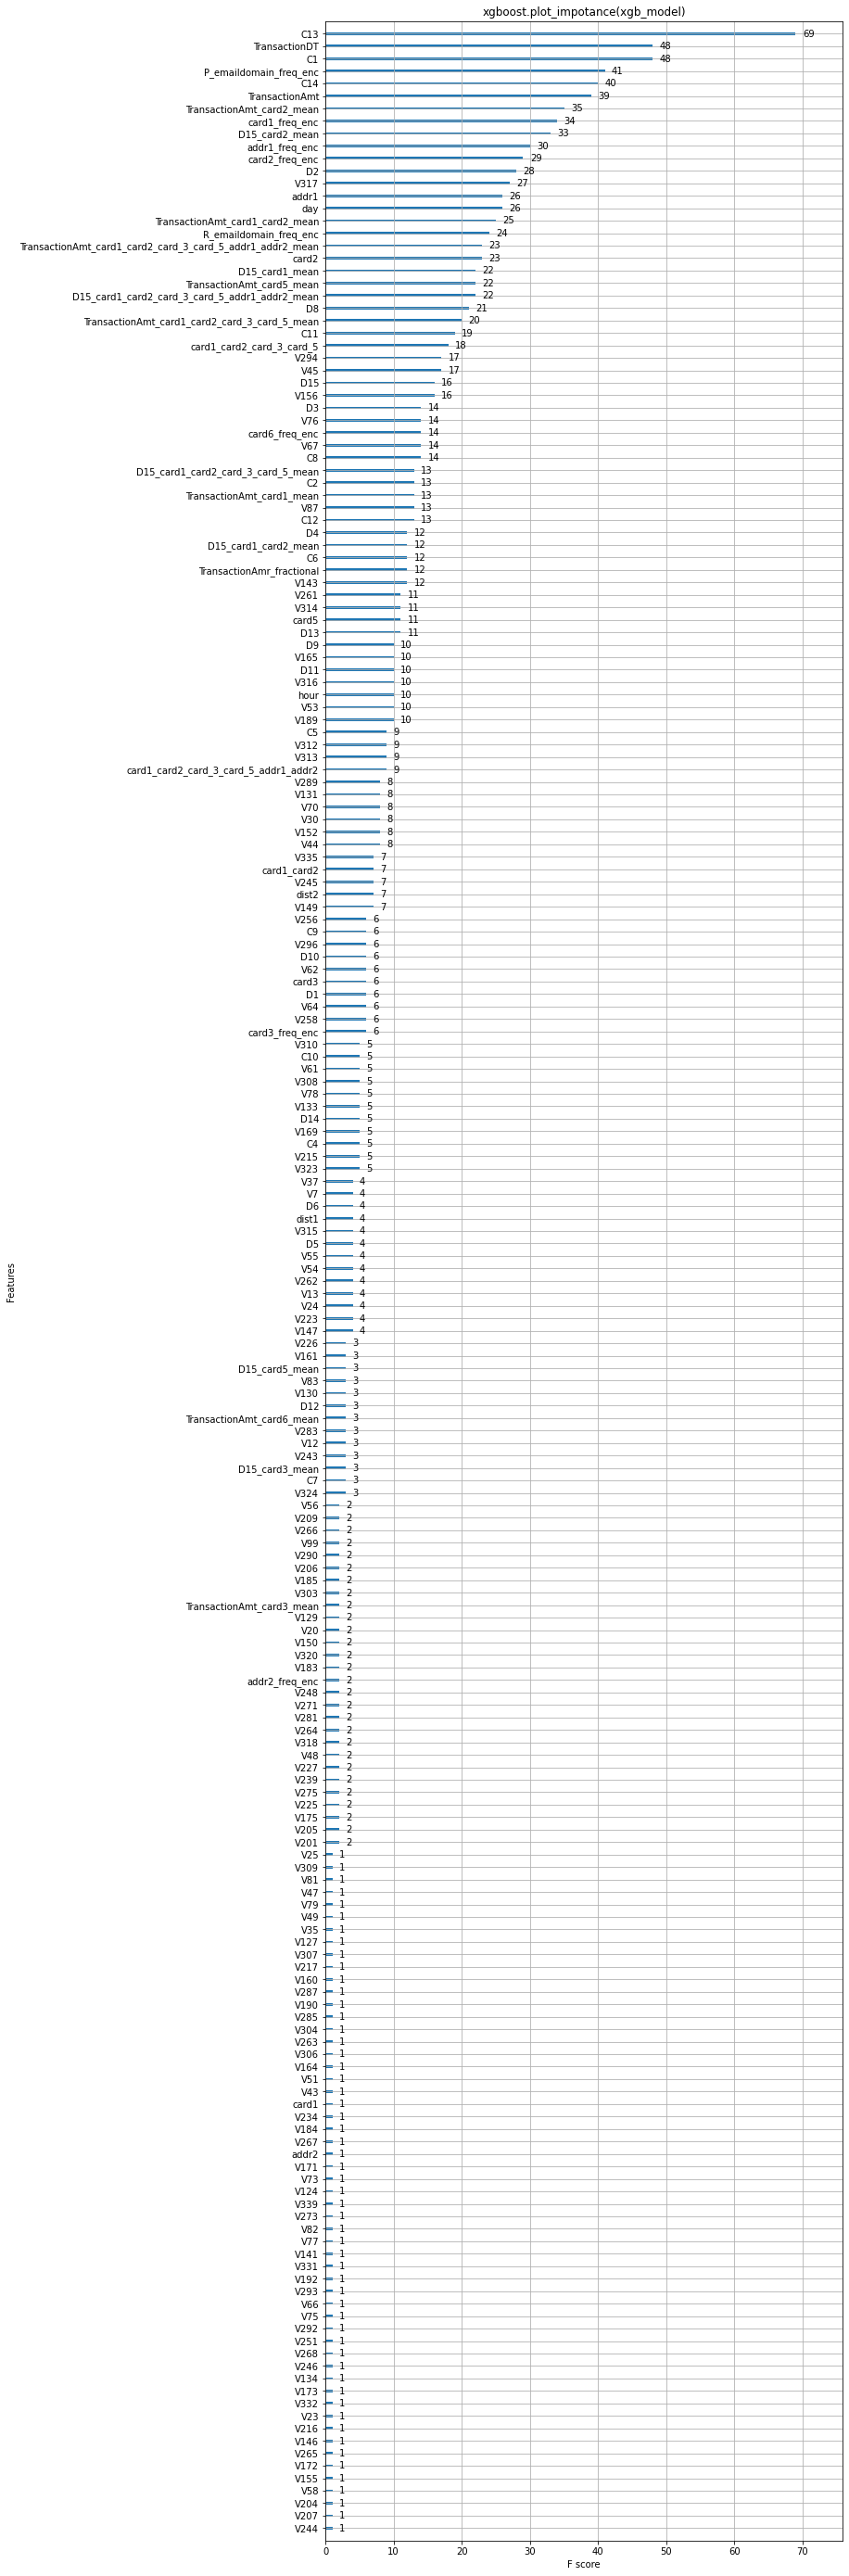

In [82]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
fig, ax = plt.subplots(1, 1, figsize=(10, 50))
xgb.plot_importance(xgb_model,ax=ax)
plt.title("xgboost.plot_impotance(xgb_model)")
pyplot.show()

## Задание 2:<a class="anchor" id="task2"></a>

Удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [145]:
# task_2_numerical_features = new_numerical_features.copy()

In [146]:
task_2_numerical_features = ['C13',  # 68
 'TransactionDT',  # 48
 'C1',  # 48
 'P_emaildomain_freq_enc',  # 41
 'C14',  # 40
 'TransactionAmt',  # 39
 'TransactionAmt_card2_mean',  # 35
 'card1_freq_enc',  # 34
 'D15_card2_mean',  # 33
 'addr1_freq_enc',  # 30
 'card2_freq_enc',  # 29
 'D2',  # 28
 'V317',  # 27
 'addr1',  # 26
 'day',  # 26
 'TransactionAmt_card1_card2_mean',  # 25
 'R_emaildomain_freq_enc',  # 24
 'TransactionAmt_card1_card2_card_3_card_5_addr1_addr2_mean',  # 23
 'card2',  # 23
 'D15_card1_mean',  # 22
 'TransactionAmt_card5_mean',  # 22
 'D15_card1_card2_card_3_card_5_addr1_addr2_mean',  # 22
 'D8',  #21
 'TransactionAmt_card1_card2_card_3_card_5_mean',  # 20
                             
 'C11',  # 19
 'card1_card2_card_3_card_5',  # 18
 'V294',  # 17
 'V45',
 'D15',  # 16
 'V156',
 'D3',  # 14
 'V76',
 'card6_freq_enc',
 'V67',
 'C8',
 'D15_card1_card2_card_3_card_5_mean',  # 13
 'C2',
 'TransactionAmt_card1_mean',
 'V87',
 'C12',
 'D4', # 12
 'D15_card1_card2_mean',
 'C6',
 'TransactionAmr_fractional',
 'V143',  # 11
 'V261',
 'V314',
 'card5',
 'D13',
                             
 'D9',  # 10
 'V165',
 'D11',
 'V316',
 'hour',
 'V53',
 'V189',
 'C5',  # 9
 'V312',
 'V313',
 'card1_card2_card_3_card_5_addr1_addr2',
 'V289', # 8
 'V131',
 'V70',
 'V30',
 'V152',
 'V44',
 'V335',  # 7
 'card1_card2',
 'V245',
 'dist2',
 'V149',
 'V256',  # 6
 'C9',
 'V296',
 'D10',
 'V62',
 'card3',
 'D1',
 'V64',
 'V258',
 'card3_freq_enc',
 'V310',  # 5
 'C10',
 'V61',
 'V308',
 'V78',
 'V133',
 'D14',
 'V169',
 'C4',
 'V215',
 'V323',
                             
 'V37',  # 4
 'V7',
 'D6',
 'dist1',
 'V315',
 'D5',
 'V55',
 'V54',
 'V262',
 'V13',
 'V24',
 'V223',
 'V147',
 'V226', # 3
 'V161',
 'D15_card5_mean',
 'V83',
 'V130',
 'D12',
 'TransactionAmt_card6_mean',
 'V283',
 'V12',
 'V243',
 'D15_card3_mean',
 'C7',
 'V324',
 'V56',  # 2
 'V209',
 'V266',
 'V99',
 'V290',
 'V206',
 'V185',
 'V303',
 'TransactionAmt_card3_mean',
 'V129',
 'V20',
 'V150',
 'V320',
 'V183',
 'addr2_freq_enc',
 'V248',
 'V271',
 'V281',
 'V264',
 'V318',
 'V48',
 'V227',
 'V239',
 'V275',
 'V225',
 'V175',
 'V205',
 'V201',
 
 'V25',  #1
 'V309',
 'V81',
 'V47',
 'V79',
 'V49',
 'V35',
 'V127',
 'V307',
 'V217',
 'V160',
 'V287',
 'V190',
 'V285',
 'V304',
 'V263',
 'V306',
 'V164',
 'V51',
 'V43',
 'card1',
 'V234',
 'V184',
 'V267',
 'addr2',
 'V171',
 'V73',
 'V124',
 'V339',
 'V273',
 'V82',
 'V77',
 'V141',
 'V331',
 'V192',
 'V293',
 'V66',
 'V75',
 'V292',
 'V251',
 'V268',
 'V246',
 'V134',
 'V173',
 'V332',
 'V23',
 'V216',
 'V146',
 'V265',
 'V172',
 'V155',
 'V58',
 'V204',
 'V207',
 'V244',
]

In [147]:
#task_2_numerical_features

In [148]:
# t = set(task_2_numerical_features)
# task_2_numerical_features = list(t)
# task_2_numerical_features

In [149]:
df_data_xgb_task_2 = df_data_xgb[task_2_numerical_features]

In [150]:
x_train_xgb, x_test_xgb = train_test_split(
    df_data_xgb_task_2, train_size=0.75, random_state=27
)
y_train_xgb, y_test_xgb = train_test_split(
    target, train_size=0.75, random_state=27
)
print("x_train.shape = {} rows, {} cols".format(*df_data_xgb_task_2.shape))
print("x_test.shape = {} rows, {} cols".format(*df_data_xgb_task_2.shape))

x_train.shape = 180000 rows, 201 cols
x_test.shape = 180000 rows, 201 cols


In [151]:
eval_sets= [
    (x_train_xgb[task_2_numerical_features], y_train_xgb),
    (x_test_xgb[task_2_numerical_features], y_test_xgb)
]

In [152]:
xgb_model_1 = xgb.XGBClassifier(**xgb_params)

xgb_model_1.fit(
    y=y_train_xgb,
    X=x_train_xgb[task_2_numerical_features],
    early_stopping_rounds=50,
    eval_set=eval_sets,
    eval_metric="auc",
    verbose=10
)

[0]	validation_0-auc:0.70651	validation_1-auc:0.69725
[10]	validation_0-auc:0.80401	validation_1-auc:0.79680
[20]	validation_0-auc:0.84378	validation_1-auc:0.83655
[30]	validation_0-auc:0.87470	validation_1-auc:0.86655
[40]	validation_0-auc:0.88669	validation_1-auc:0.87788
[50]	validation_0-auc:0.89773	validation_1-auc:0.88661
[60]	validation_0-auc:0.90369	validation_1-auc:0.89160
[70]	validation_0-auc:0.90805	validation_1-auc:0.89507
[80]	validation_0-auc:0.91243	validation_1-auc:0.89797
[90]	validation_0-auc:0.91543	validation_1-auc:0.90039
[99]	validation_0-auc:0.91709	validation_1-auc:0.90143


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

__Базовое качество модели:__

[180] validation_0-auc:0.92789 validation_1-auc:0.90977 (417 cols)

__Учёт вклада полей в модель (F score):__

    > 20 [110]	validation_0-auc:0.90674	validation_1-auc:0.88975 (24 cols)
    > 10 [160]	validation_0-auc:0.92392	validation_1-auc:0.90668 (49 cols)
    > 4 [150]	validation_0-auc:0.92500	validation_1-auc:0.90742 (92 cols)
    > 1 [150]	validation_0-auc:0.92549	validation_1-auc:0.90781 (146 cols)
    = 1 [180]	validation_0-auc:0.92789	validation_1-auc:0.90976 (201 cols)

## Задание 3:<a class="anchor" id="task3"></a>

Использовать permutation importance , выполнить задание 1 и 2.

https://habr.com/ru/company/otus/blog/464695/ - Интерпретируемая модель машинного обучения. Часть 1

In [115]:
from copy import deepcopy

xgb_params = deepcopy(xgb_params)
xgb_params["n_estimators"] = 100

In [153]:
conda install -c conda-forge eli5

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

# All requested packages already installed.




In [158]:
df_data_xgb = data[new_numerical_features + new_categorical_features]

In [159]:
df_data_xgb['card1_card2'] = df_data_xgb.card1_card2.replace('', np.nan).astype(float)
df_data_xgb['card1_card2_card_3_card_5'] = df_data_xgb.card1_card2_card_3_card_5.replace('', np.nan).astype(float)
df_data_xgb['card1_card2_card_3_card_5_addr1_addr2'] = df_data_xgb.card1_card2_card_3_card_5_addr1_addr2.replace('', np.nan).astype(float)
df_data_xgb['card4_freq_enc'] = df_data_xgb.card4_freq_enc.replace('', np.nan).astype(float)
df_data_xgb['card6_freq_enc'] = df_data_xgb.card6_freq_enc.replace('', np.nan).astype(float)
df_data_xgb['addr1_freq_enc'] = df_data_xgb.addr1_freq_enc.replace('', np.nan).astype(float)

In [160]:
x_train_xgb, x_test_xgb = train_test_split(
    df_data_xgb, train_size=0.75, random_state=27
)
y_train_xgb, y_test_xgb = train_test_split(
    target, train_size=0.75, random_state=27
)
print("x_train.shape = {} rows, {} cols".format(*x_train_xgb.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test_xgb.shape))

x_train.shape = 135000 rows, 417 cols
x_test.shape = 45000 rows, 417 cols


In [161]:
eval_sets= [
    (x_train_xgb[new_numerical_features + new_categorical_features], y_train_xgb),
    (x_test_xgb[new_numerical_features + new_categorical_features], y_test_xgb)
]

In [162]:
xgb_model_0 = xgb.XGBClassifier(**xgb_params)

xgb_model_0.fit(
    y=y_train_xgb,
    X=x_train_xgb[new_numerical_features + new_categorical_features],
    early_stopping_rounds=50,
    eval_set=eval_sets,
    eval_metric="auc",
    verbose=10
)

[0]	validation_0-auc:0.70651	validation_1-auc:0.69725
[10]	validation_0-auc:0.80401	validation_1-auc:0.79680
[20]	validation_0-auc:0.84378	validation_1-auc:0.83655
[30]	validation_0-auc:0.87470	validation_1-auc:0.86655
[40]	validation_0-auc:0.88669	validation_1-auc:0.87788
[50]	validation_0-auc:0.89773	validation_1-auc:0.88661
[60]	validation_0-auc:0.90369	validation_1-auc:0.89161
[70]	validation_0-auc:0.90805	validation_1-auc:0.89508
[80]	validation_0-auc:0.91243	validation_1-auc:0.89797
[90]	validation_0-auc:0.91543	validation_1-auc:0.90039
[99]	validation_0-auc:0.91709	validation_1-auc:0.90144


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [119]:
import eli5
from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(model, random_state=27).fit(val_x, val_y)
# perm = PermutationImportance(model, scoring='roc_auc', random_state=27).fit(val_x, val_y)
# eli5.show_weights(perm, feature_name = val_X.columns.tolist())

In [122]:
perm_0 = PermutationImportance(xgb_model_0, random_state=27).fit(x_test_xgb, y_test_xgb)

In [132]:
eli5.show_weights(perm_0, feature_names = x_test_xgb.columns.tolist(), top = 100)

Weight,Feature
0.0034 ± 0.0004,C13
0.0016 ± 0.0001,V317
0.0012 ± 0.0003,C1
0.0006 ± 0.0001,C8
0.0005 ± 0.0002,V30
0.0004 ± 0.0001,C14
0.0004 ± 0.0001,V67
0.0003 ± 0.0004,TransactionDT
0.0003 ± 0.0001,C11
0.0003 ± 0.0001,P_emaildomain_freq_enc


In [135]:
task_3_numerical_features = [
'C13',  # 0.0034 ± 0.0004
'V317',  # 0.0016 ± 0.0001
'C1',  # 0.0012 ± 0.0003
'C8',  # 0.0006 ± 0.0001
'V30',  # 0.0005 ± 0.0002
'C14',  # 0.0004 ± 0.0001
'V67',  # 0.0004 ± 0.0001
'TransactionDT',  # 0.0003 ± 0.0004
'C11',  # 0.0003 ± 0.0001
'P_emaildomain_freq_enc',  # 0.0003 ± 0.0001

'D2',  # 0.0003 ± 0.0001
'D15_card2_mean',  # 0.0003 ± 0.0002
'V156',  # 0.0003 ± 0.0000
'V294',  # 0.0003 ± 0.0000
'V70',  # 0.0003 ± 0.0002
'V258',  # 0.0003 ± 0.0001
'C4',  # 0.0002 ± 0.0001
'V45',  # 0.0002 ± 0.0001
'V308',  # 0.0002 ± 0.0000
'card2_freq_enc',  # 0.0002 ± 0.0001

'V62',  # 0.0002 ± 0.0001
'V314',  # 0.0002 ± 0.0001
'card1_freq_enc',  # 0.0002 ± 0.0001
'addr1_freq_enc',  # 0.0002 ± 0.0002
'card3',  # 0.0002 ± 0.0001
'V313',  # 0.0002 ± 0.0001
'TransactionAmt',  # 0.0002 ± 0.0001
'addr1',  # 0.0002 ± 0.0001
'V261',  # 0.0002 ± 0.0000
'V289',  # 0.0002 ± 0.0000

'card1_card2_card_3_card_5',  # 0.0002 ± 0.0002
'C5',  # 0.0002 ± 0.0001
'TransactionAmt_card1_card2_card_3_card_5_addr1_addr2_mean',  # 0.0002 ± 0.0001
'D15_card1_card2_card_3_card_5_addr1_addr2_mean',  # 0.0002 ± 0.0001
'C12',  # 0.0002 ± 0.0001
'TransactionAmt_card2_mean',  # 0.0002 ± 0.0001
'C2',  # 0.0002 ± 0.0001
'V283',  # 0.0002 ± 0.0001
'V143',  # 0.0002 ± 0.0001
'R_emaildomain_freq_enc',  # 0.0002 ± 0.0001

'V87',  # 0.0002 ± 0.0001
'D15',  # 0.0001 ± 0.0001
'V133',  # 0.0001 ± 0.0000
'V78',  # 0.0001 ± 0.0000
'card2',  # 0.0001 ± 0.0001
'card5',  # 0.0001 ± 0.0001
'V131',  # 0.0001 ± 0.0001
'V149',  # 0.0001 ± 0.0001
'C6',  # 0.0001 ± 0.0001
'V134',  # 0.0001 ± 0.0000

'D15_card1_mean',  # 0.0001 ± 0.0001
'D14',  # 0.0001 ± 0.0001
'C10',  # 0.0001 ± 0.0000
'TransactionAmt_card1_card2_card_3_card_5_mean',  # 0.0001 ± 0.0001
'card1_card2_card_3_card_5_addr1_addr2',  # 0.0001 ± 0.0000
'D3',  # 0.0001 ± 0.0000
'V335',  # 0.0001 ± 0.0000
'D8',  # 0.0001 ± 0.0001
'TransactionAmt_card1_mean',  # 0.0001 ± 0.0000
'V312',  # 0.0001 ± 0.0000

'V61',  # 0.0001 ± 0.0001
'D9',  # 0.0001 ± 0.0001
'hour',  # 0.0001 ± 0.0000
'V262',  # 0.0001 ± 0.0000
'V310',  # 0.0001 ± 0.0001
'D15_card5_mean',  # 0.0001 ± 0.0000
'V13',  # 0.0001 ± 0.0000
'V287',  # 0.0001 ± 0.0000
'D15_card1_card2_mean',  # 0.0001 ± 0.0001
'V281',  # 0.0001 ± 0.0000

'TransactionAmr_fractional',  # 0.0001 ± 0.0000
'V51',  # 0.0001 ± 0.0000
'V152',  # 0.0001 ± 0.0001
'V225',  # 0.0001 ± 0.0001
'V129',  # 0.0001 ± 0.0000
]

In [139]:
df_data_xgb_task_3 = df_data_xgb[task_3_numerical_features]

In [140]:
x_train_xgb, x_test_xgb = train_test_split(
    df_data_xgb_task_3, train_size=0.75, random_state=27
)
y_train_xgb, y_test_xgb = train_test_split(
    target, train_size=0.75, random_state=27
)
print("x_train.shape = {} rows, {} cols".format(*df_data_xgb_task_2.shape))
print("x_test.shape = {} rows, {} cols".format(*df_data_xgb_task_2.shape))

x_train.shape = 180000 rows, 75 cols
x_test.shape = 180000 rows, 75 cols


In [142]:
eval_sets= [
    (x_train_xgb[task_3_numerical_features], y_train_xgb),
    (x_test_xgb[task_3_numerical_features], y_test_xgb)
]

In [143]:
xgb_model_2 = xgb.XGBClassifier(**xgb_params)

xgb_model_2.fit(
    y=y_train_xgb,
    X=x_train_xgb[task_3_numerical_features],
    early_stopping_rounds=50,
    eval_set=eval_sets,
    eval_metric="auc",
    verbose=10
)

[0]	validation_0-auc:0.66434	validation_1-auc:0.65607
[10]	validation_0-auc:0.80704	validation_1-auc:0.80065
[20]	validation_0-auc:0.84438	validation_1-auc:0.83775
[30]	validation_0-auc:0.87472	validation_1-auc:0.86862
[40]	validation_0-auc:0.88691	validation_1-auc:0.87857
[50]	validation_0-auc:0.89543	validation_1-auc:0.88609
[60]	validation_0-auc:0.90085	validation_1-auc:0.88962
[70]	validation_0-auc:0.90590	validation_1-auc:0.89280
[80]	validation_0-auc:0.90926	validation_1-auc:0.89497
[90]	validation_0-auc:0.91177	validation_1-auc:0.89663
[99]	validation_0-auc:0.91377	validation_1-auc:0.89831


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

__Базовое качество модели:__

[180] validation_0-auc:0.92789 validation_1-auc:0.90977 (417 cols)

__Учёт вклада полей в модель (F score):__

    > 0 [99]	validation_0-auc:0.91377	validation_1-auc:0.89831 (75 cols)

## Задание 4:<a class="anchor" id="task4"></a>

Использовать shap, выполнить задание 1 и 2.

## Задание 5:<a class="anchor" id="task5"></a>

Построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

https://www.machinelearningmastery.ru/catboost-vs-light-gbm-vs-xgboost-5f93620723db/ - CatBoost против Light GBM против XGBoost

https://developer.nvidia.com/blog/leveraging-machine-learning-to-detect-fraud-tips-to-developing-a-winning-kaggle-solution/ - Leveraging Machine Learning to Detect Fraud: Tips to Developing a Winning Kaggle Solution